## Consider the following PDEs
$$
\frac{\partial u}{\partial t}
+ u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y}
=
-\frac{1}{\rho} \frac{\partial p}{\partial x}
+ \nu \left(
\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}
\right)
$$
\
$$
\frac{\partial v}{\partial t}
+ u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y}
=
-\frac{1}{\rho} \frac{\partial p}{\partial y}
+ \nu \left(
\frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2}
\right)
\\[10pt]
$$
\
$$
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0
$$
Or alternatively, we can use
\
$$
\left( \frac{\partial u}{\partial x} \right)^2 +
2 \left( \frac{\partial u}{\partial y} \right)
\left( \frac{\partial v}{\partial x} \right) +
\left( \frac{\partial v}{\partial y} \right)^2
= -\frac{1}{\rho}
\left(
\frac{\partial^2 p}{\partial x^2}
+ \frac{\partial^2 p}{\partial y^2}
\right)
$$


The boundary conditions for the velocity are the following.
<br><br>
$$
u(t, x, l_y) = 1, \quad u(t, x, 0) = 0, \quad
u(t, 0, y) = 0, \quad u(t, l_x, y) = 0
$$
\
$$
v(t, x, l_y) = 0, \quad v(t, x, 0) = 0, \quad
v(t, 0, y) = 0, \quad v(t, l_x, y) = 0
$$

consider $l_x = l_y = 1$

<br><br>
The boundary condition for the pressure
<br><br>
$$
\frac{\partial p}{\partial x}\Big|_{x=0} = 0, \quad
\frac{\partial p}{\partial x}\Big|_{x=l_x} = 0, \quad
\frac{\partial p}{\partial y}\Big|_{y=0} = 0, \quad
p(t, x, l_y) = 0
$$
<br><br>
We will approximate the solution of the PDEs system using the finite difference method and the physics informed neural network and we will compare the resuts of the two methods.
For the details of the finite difference method and the discretization refer to the report.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt

##Functions to plot the outputs (pressure, velocities)

In [2]:
def plot_pressure_velocity(x, y, u, v, p):
  X, Y = np.meshgrid(x, y)
  figure, axs = plt.subplots(1, 3, figsize=(10, 3), tight_layout=True)
  output = [p, u, v]
  title = ["Pressure", "Velocity u", "Velocity v"]
  for i in range(len(axs)):
    ax = axs[i]
    ax.set_title(title[i])
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    colormap = ax.pcolormesh(X, Y, output[i], cmap="jet", shading="auto")
    figure.colorbar(colormap, ax=ax)
  plt.show()

def plot_stream_lines(x, y, u, v, p):
  X, Y = np.meshgrid(x, y)
  figure = plt.figure(figsize=(5, 4), tight_layout=True, dpi=120)
  ax = figure.add_subplot(111)
  ax.set_xlim(x[0], x[-1])
  ax.set_ylim(y[0], y[-1])
  ax.set_title("Velocity vector lines & Pressure")
  ax.set_xlabel("x")
  ax.set_ylabel("y")
  colormap = ax.pcolormesh(X, Y, p, cmap="jet", shading="auto")
  figure.colorbar(colormap)
  plt.streamplot(X, Y, u, v, color="black")
  plt.show()

In [3]:
def plot_final_t_step(pinn, t, vector_lines=True):
  #create test input data
  x_test = torch.linspace(x_0, x_f, 50).to(device)
  y_test = torch.linspace(y_0, y_f , 50).to(device)
  test_data = torch.cartesian_prod(x_test, y_test, torch.tensor([t]).to(device))
  x_input_test, y_input_test, t_input_test = torch.split(test_data, 1, 1)

  #create a mesh
  x_test, y_test = x_test.cpu(), y_test.cpu()
  output_shape = (len(y_test), len(x_test))
  # x_grid, y_grid = torch.meshgrid(x_test, y_test, indexing="xy")

  #get the output of the PINN
  u_test, v_test, p_test = pinn(x_input_test, y_input_test, t_input_test)
  u_test = u_test.squeeze().reshape(output_shape).cpu().numpy()
  v_test = v_test.squeeze().reshape(output_shape).cpu().numpy()
  p_test = p_test.squeeze().reshape(output_shape).cpu().numpy()

  #plot the output
  if vector_lines:
    plot_stream_lines(x_test, y_test, u_test, v_test, p_test)

  else:
    plot_pressure_velocity(x_test, y_test, u_test.T, v_test.T, p_test.T)

# Finite Difference Method (FDM)

## Define some consatns

In [4]:
DENSITY = 1.0
VISCOSITY = 0.1
X_BOUNDARY = (0.0, 1.0)
Y_BOUNDARY = (0.0, 1.0)
X_POINTS_NUM = 50
Y_POINTS_NUM = 50
T_STEP_SIZE = 0.001
HORIZENTOL_VEL = 1.0

In [5]:
x_fd = np.linspace(*X_BOUNDARY, X_POINTS_NUM)
y_fd = np.linspace(*Y_BOUNDARY, Y_POINTS_NUM)
X_STEP_SIZE = x_fd[1] - x_fd[0]
Y_STEP_SIZE = y_fd[1] - y_fd[0]
C =  ( X_STEP_SIZE**2 * Y_STEP_SIZE**2 * DENSITY ) / ( 2 * (X_STEP_SIZE**2 + Y_STEP_SIZE**2) )

## Finite Difference Formulas

In [6]:
#The central finite difference for second derivative with respect to x
def cent_diff_2nd_der_x(grid):
  output = np.copy(grid)
  output[1:-1, 1:-1] = (
      grid[1:-1, 2:]
      -
      2 * grid[1:-1, 1:-1]
      +
      grid[1:-1, :-2]
  ) / X_STEP_SIZE**2
  return output

#The central finite difference for second derivative with respect to y
def cent_diff_2nd_der_y(grid):
  output = np.copy(grid)
  output[1:-1, 1:-1] = (
      grid[2:, 1:-1]
      -
      2 * grid[1:-1, 1:-1]
      +
      grid[:-2, 1:-1]
  ) / Y_STEP_SIZE**2
  return output

#The centeral fintie difference for the first derivative with respect to x
def cent_diff_1st_der_x(grid):
  output = np.copy(grid)
  output[1:-1, 1:-1] = (
      grid[1:-1, 2:]
      -
      grid[1:-1, :-2]
  ) / ( 2 * X_STEP_SIZE )
  return output

#The centeral fintie difference for the first derivative with respect to y
def cent_diff_1st_der_y(grid):
  output = np.copy(grid)
  output[1:-1, 1:-1] = (
      grid[2:, 1:-1]
      -
      grid[:-2, 1:-1]
  ) / (2 * Y_STEP_SIZE)
  return output

#The backwaed difference for the derivative with repsect to x
def backward_diff_der_x(grid):
  output = np.copy(grid)
  output[1:-1, 1:] = (
      grid[1:-1, 1:]
      -
      grid[1:-1, :-1]
  ) / X_STEP_SIZE
  return output

#The backwaed difference for the derivative with repsect to x
def backward_diff_der_y(grid):
  output = np.copy(grid)
  output[:-1, 1:-1] = (
      grid[1:, 1:-1]
      -
      grid[:-1, 1:-1]
  ) / Y_STEP_SIZE
  return output

def pressure_diff_x(grid):
  output = np.copy(grid)
  output[1:-1, 1:-1] = (
      grid[1:-1, 2:]
      +
      grid[1:-1, :-2]
  ) / X_STEP_SIZE**2
  return output

def pressure_diff_y(grid):
  output = np.copy(grid)
  output[1:-1, 1:-1] = (
      grid[2:, 1:-1]
      +
      grid[:-2, 1:-1]
  )/ Y_STEP_SIZE**2
  return output

## Define the boundary conditions

In [7]:
#apply boundary condition to x-component of the velocity
def u_boundary_condition(grid):
  grid[:, 0] = 0.0
  grid[:, -1] = 0.0
  grid[0, :] = 0.0
  grid[-1, :] = HORIZENTOL_VEL

#apply boundary condition to y-component of the velocity
def v_boundary_condition(grid):
  grid[:, 0] = 0.0
  grid[:, -1] = 0.0
  grid[0, :] = 0.0
  grid[-1, :] = 0.0

#Apply pressure boundary condition
def p_boundary_condition(grid):
  grid[:, -1] = grid[:, -2]
  grid[:, 0] = grid[:, 1]
  grid[0, :] = grid[1, :]
  grid[-1, :] = 0.0

## Apply FDM

In [8]:
def simulate_FD(iter=1000):

  #Initilaize the velocities and the pressure
  u_prev = np.zeros( (len(y_fd), len(x_fd)) )
  v_prev = np.zeros( (len(y_fd), len(x_fd)) )
  p_prev = np.zeros( (len(y_fd), len(x_fd)) )

  #apply the boundary conditions
  u_boundary_condition(u_prev)
  v_boundary_condition(v_prev)
  p_boundary_condition(p_prev)

  for _ in range(iter):
    #u_next
    u_next = u_prev + T_STEP_SIZE * (
        - u_prev * cent_diff_1st_der_x(u_prev)
        - v_prev * cent_diff_1st_der_y(u_prev)
        - (1/DENSITY) * cent_diff_1st_der_x(p_prev)
        + VISCOSITY * ( cent_diff_2nd_der_x(u_prev) + cent_diff_2nd_der_y(u_prev) )
    )
    u_boundary_condition(u_next)

    #v_next
    v_next = v_prev + T_STEP_SIZE * (
        - u_prev * cent_diff_1st_der_x(v_prev)
        - v_prev * cent_diff_1st_der_y(v_prev)
        - (1/DENSITY) * cent_diff_1st_der_y(p_prev)
        + VISCOSITY * ( cent_diff_2nd_der_x(v_prev) + cent_diff_2nd_der_y(v_prev) )
    )
    v_boundary_condition(v_next)

    #update
    u_prev = u_next
    v_prev = v_next

    #Compute the pressure
    for _ in range(50):
      p_next = C * (
          pressure_diff_x(p_prev) + pressure_diff_y(p_prev)
          - DENSITY * (
              (1/T_STEP_SIZE) * (cent_diff_1st_der_x(u_prev) + cent_diff_1st_der_y(v_prev) )
              - cent_diff_1st_der_x(u_prev)**2
              - 2 * cent_diff_1st_der_y(u_prev) * cent_diff_1st_der_x(v_prev)
              - cent_diff_1st_der_y(v_prev)**2
          )
      )
      p_boundary_condition(p_next)
      p_prev = p_next

  return u_next, v_next, p_next

### Perform the simulation

In [9]:
u_fd, v_fd, p_fd = simulate_FD()

### Show the fluid behavior

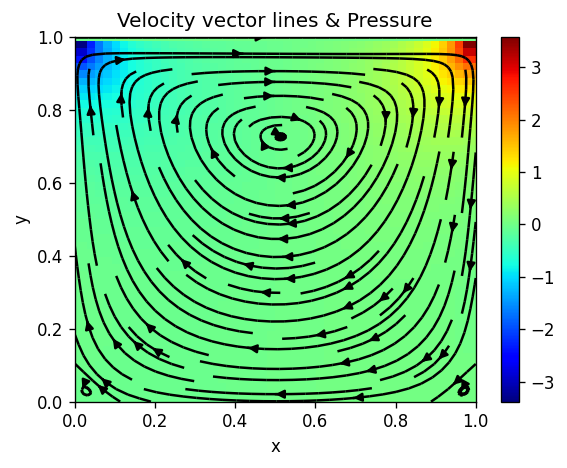

In [10]:
plot_stream_lines(x_fd, y_fd, u_fd, v_fd, p_fd)

### plot the velocities and the pressure

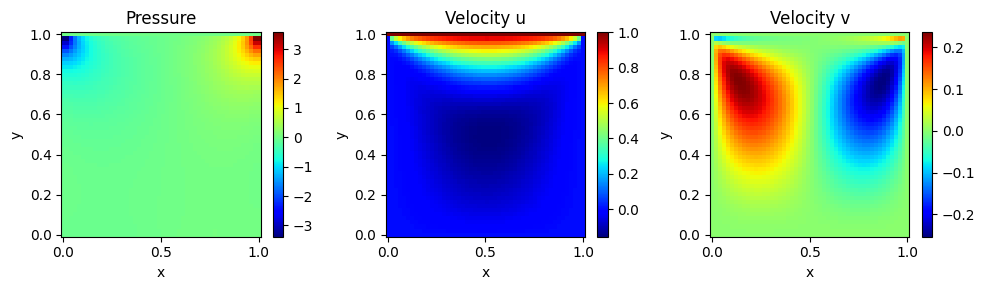

In [11]:
plot_pressure_velocity(x_fd, y_fd, u_fd, v_fd, p_fd)

# PINNs (Physics Informed Neural Networks)
Physics-Informed Neural Networks (PINNs) represent a groundbreaking approach that marries the capabilities of neural networks with the governing physics equations of a system. The core idea is to integrate the underlying physical principles into the learning process, enabling the neural network to capture both the empirical data and the fundamental laws that govern the system. In the context of fluid dynamics and the Navier-Stokes equations, PINNs provide an avenue to circumvent some of the limitations of traditional numerical methods.


## Formulation:

The central concept behind PINNs lies in constructing a neural network that approximates the solution to the fluid dynamics problem. This neural network is trained not only to fit the available data but also to satisfy the governing equations. For the Navier-Stokes equations, the loss function, which the network aims to minimize during training, consists of:



### Physics Loss:
 This term enforces the satisfaction of the Navier-Stokes equations. By incorporating these equations into the loss function, the network is compelled to learn a solution that adheres to the fundamental principles of fluid dynamics. Mathematically, the physics loss can be expressed as the residual of the Navier-Stokes equations.

### Boundary Loss:
This term enforces the satisfaction of the boundary condition for $u,v,p$ on each axis whether it's neuman boundary condition or dirchlit boundary conditions.

### Initial Loss:
This term enforces the satisfaction of the initial value loss when $t=0$ on the equation

#### The neural network visualisation

<img src="NN1.png" alt="Sample Image" width="800"/>


## Methodology
As the figure suggests, we would use 5 hidden layers with activation function $\tanh$ which works best with PINNs, we added 32 parameters for each layer to give us 3 outpus which are $u,v,p$.

## Evaluation

We trained the model to approximate the solution for navier-stokes equation for different values of $t$


## Use GPU (If available)

In [12]:
# set the device to be a GPU, if it is there
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Define the neural network

In [13]:
# the model
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
            nn.Linear(N_INPUT, N_HIDDEN).to(device),
            activation()

        ])


        self.fch =nn.Sequential(*[ nn.Sequential(*[
            nn.Linear(N_HIDDEN, N_HIDDEN).to(device),
            activation()

        ]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN,N_OUTPUT).to(device)
        def weights_initialization(self):
                """"
                When we define all the modules such as the layers in '__init__()'
                method above, these are all stored in 'self.modules()'.
                We go through each module one by one. This is the entire network,
                basically.
                """
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight,gain=1.0)
                nn.init.constant_(m.bias, 0)
    def forward(self, x, y, t):
        inputs = torch.cat((x, y, t), dim=1)
        inputs = self.fcs(inputs)
        inputs = self.fch(inputs)
        output = self.fce(inputs)

        # Split the output into u, v, and p
        u, v, p = torch.split(output, 1, dim=1)
        return u, v, p

## Input Data Generation

In [14]:
x_0, x_f = 0.0, 1.0
y_0, y_f = 0.0, 1.0
t_0, t_f = 0.0 , 1.0

In [15]:
def generate_data(x_num = 10, y_num=10, t_num=10):
    x_axis = torch.linspace(x_0, x_f,  x_num + 2)[1:-1] #exclude the boundary
    y_axis = torch.linspace(y_0, y_f, y_num + 2)[1: -1]
    t_axis = torch.linspace(t_0, t_f, t_num )
    data = torch.cartesian_prod(x_axis, y_axis, t_axis)
    return torch.split(data, 1, 1)

In [16]:
# Input points from the interior of the domain
x_physics , y_physics, t_physics = generate_data(15, 15, 15)
x_physics = x_physics.requires_grad_().to(device)
y_physics = y_physics.requires_grad_().to(device)
t_physics = t_physics.requires_grad_().to(device)
examples_num = len(x_physics)

#Points from the domain at Boundary
y_up = torch.tensor( [y_f]*examples_num ).unsqueeze(-1).to(device)
y_down = torch.tensor( [y_0]*examples_num ).unsqueeze(-1).requires_grad_().to(device)
x_right = torch.tensor( [x_f]*examples_num ).unsqueeze(-1).requires_grad_().to(device)
x_left = torch.tensor( [x_0]*examples_num ).unsqueeze(-1).requires_grad_().to(device)

#Initial values at t = 0
x_interior = torch.linspace(x_0, x_f, 17)[1:-1]
y_interior = torch.linspace(y_0, y_f, 17)[1:-1]
initial_points = torch.cartesian_prod(x_interior, y_interior, torch.tensor([t_0]))
x_interior, y_interior, t_initial = torch.split(initial_points.to(device), 1, 1)

## Function to compute the PDE losses

In [17]:
def pde_loss(x, y, t, net, density=DENSITY, viscosity=VISCOSITY):
    u, v, p = net(x,y,t)
    u_x = torch.autograd.grad(u, x,torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x),create_graph=True)[0]
    u_y = torch.autograd.grad(u, y,torch.ones_like(u), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y,torch.ones_like(u_y), create_graph=True)[0]
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]

    v_x = torch.autograd.grad(v, x,torch.ones_like(v), create_graph=True)[0]
    v_xx = torch.autograd.grad(v_x, x, torch.ones_like(v_x),create_graph=True)[0]
    v_y = torch.autograd.grad(v, y,torch.ones_like(v), create_graph=True)[0]
    v_yy = torch.autograd.grad(v_y, y,torch.ones_like(v_y), create_graph=True)[0]
    v_t = torch.autograd.grad(v,t,torch.ones_like(v), create_graph=True)[0]

    p_x = torch.autograd.grad(p,x,torch.ones_like(p), create_graph=True)[0]
    p_y = torch.autograd.grad(p,y,torch.ones_like(p), create_graph=True)[0]

    # Compute PDE losses
    pde1 = u_t + u * u_x + v * u_y + (1/density) * p_x - viscosity * (u_xx + u_yy)
    pde2 = v_t + u * v_x + v * v_y + (1/density) * p_y - viscosity * (v_xx + v_yy)
    pde3 = u_x + v_y

    # Store losses in a dictionary
    losses = {
        'PDE1': pde1,
        'PDE2': pde2,
        'PDE3': pde3
    }
    loss_added = torch.mean(pde1**2) + torch.mean(pde2**2) + torch.mean(pde3**2)

    return losses, loss_added

## Initialize the neural network

In [23]:
pinn = FCN(3,3,128,7)
mse_cost_function = torch.nn.MSELoss()
optimizer = optim.Adam(pinn.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.45)

## Start training the NN

u: 0.0067105782218277454, v: 0.0015953333349898458, p:0.0007990270387381315, pde:0.002758560236543417


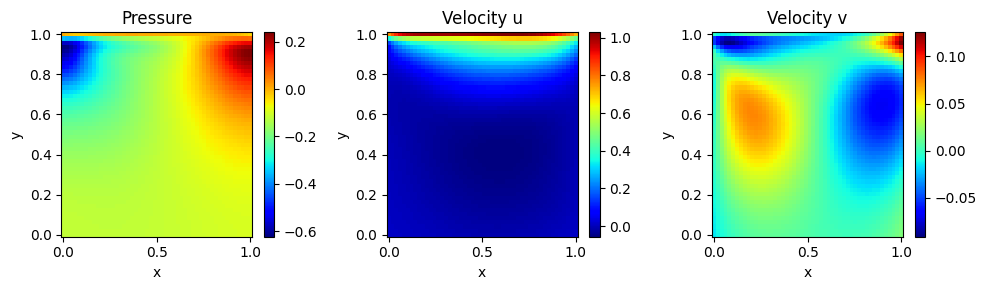

In [30]:
total_losses = []
iteration = []
boundary_loss = []
epochs = 15000

pinn.train()
for epoch in range(1, epochs + 1):

    optimizer.zero_grad()

    #Initial value loss
    u, v, p = pinn(x_interior, y_interior, t_initial)
    u_initial_loss = torch.mean( u**2 )
    v_initial_loss = torch.mean( v**2 )
    p_initial_loss = torch.mean( p**2 )
    initial_loss = u_initial_loss + v_initial_loss + p_initial_loss

    #Boundary loss, 1- top "y=1"
    u, v , p = pinn(x_physics, y_up, t_physics)
    u_top_loss = torch.mean( (u-1)**2 )
    v_top_loss = torch.mean( v**2 )
    p_top_loss = torch.mean( p**2 )
    top_loss = u_top_loss + v_top_loss + p_top_loss

    #Boundary loss, 2 - down "y=0"
    u, v , p = pinn(x_physics, y_down, t_physics)
    u_down_loss = torch.mean( u**2 )
    v_down_loss = torch.mean( v**2 )
    p_y = torch.autograd.grad(p, y_down, torch.ones_like(p), create_graph=True)[0]
    p_down_loss = torch.mean( p_y**2 )
    down_loss = u_down_loss + v_down_loss + p_down_loss

    # Boundary loss, 3 - left "x=0"
    u, v , p = pinn(x_left, y_physics, t_physics)
    u_left_loss = torch.mean( u**2 )
    v_left_loss = torch.mean( v**2 )
    p_x = torch.autograd.grad(p, x_left, torch.ones_like(p), create_graph=True)[0]
    p_left_loss = torch.mean( p_x**2 )
    left_loss = u_left_loss + v_left_loss + p_left_loss

    # Boundary loss, 4 - right "x=1"
    u, v , p = pinn(x_right, y_physics, t_physics)
    u_right_loss = torch.mean( u**2 )
    v_right_loss = torch.mean( v**2 )
    p_x = torch.autograd.grad(p, x_right, torch.ones_like(p), create_graph=True)[0]
    p_right_loss = torch.mean( p_x**2 )
    right_loss = u_right_loss + v_right_loss + p_right_loss

    #losses for each variable u, v, p
    u_loss = u_initial_loss + u_top_loss + u_left_loss + u_down_loss + u_right_loss
    v_loss = v_initial_loss + v_top_loss + v_left_loss + v_down_loss + v_right_loss
    p_loss = p_initial_loss + p_top_loss + p_left_loss + p_down_loss + p_right_loss

    # pde loss
    pde_losses, losses_added = pde_loss(x = x_physics, y = y_physics, t = t_physics, net = pinn  )
    loss = losses_added +  top_loss + down_loss + right_loss + left_loss + initial_loss

    # back propagation
    loss.backward()
    optimizer.step()

    if epoch % 2500 == 0:
      scheduler.step()
      pinn.eval()
      # print(f"u: {u_loss.item()}, v: {v_loss.item()}, p:{p_loss.item()}, pde:{losses_added.item()}")
      print(f"top: {top_loss.item()}, right: {right_loss.item()}, down:{down_loss.item()}, left: {left_loss.item()}")
      print(f"initial loss: {initial_loss.item()} pde:{losses_added.item()}")
      with torch.inference_mode():
        plot_final_t_step(pinn, t=t_f, vector_lines=False)
      pinn.train()

# Comapring FD with PINN
In this part, we will compare the results obtained using the finite difference with the results obtained through the physics-informed neural network in terms of velocity. The values of the pressure differes greatly between the two, but what is more important is the value of the pressure gradient.

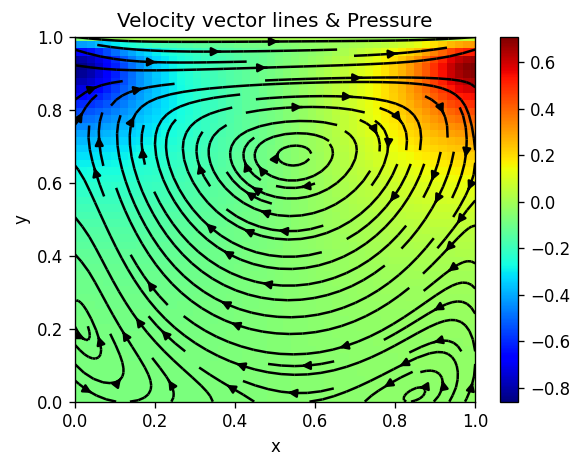

In [33]:
# To compare the two methods, the output must have
# the same resolution.
pinn.eval()
with torch.inference_mode():
  x_test = torch.linspace(x_0, x_f, 50).to(device)
  y_test = torch.linspace(y_0, y_f , 50).to(device)
  test_data = torch.cartesian_prod(x_test, y_test, torch.tensor([t_f]).to(device))
  x_input_test, y_input_test, t_input_test = torch.split(test_data, 1, 1)

  x_test, y_test = x_test.cpu(), y_test.cpu()
  x_grid, y_grid = torch.meshgrid(x_test, y_test, indexing="xy")
  u_pinn, v_pinn, p_pinn = pinn(x_input_test, y_input_test, t_input_test)
  u_pinn = u_pinn.squeeze().reshape(x_grid.shape).T.cpu().numpy()
  v_pinn = v_pinn.squeeze().reshape(x_grid.shape).T.cpu().numpy()
  p_pinn = p_pinn.squeeze().reshape(x_grid.shape).T.cpu().numpy()
  u_diff = abs(u_pinn - u_fd)
  v_diff = abs(v_pinn - v_fd)
  p_diff = abs(p_pinn - p_fd)
  plot_stream_lines(x_test, y_test, u_pinn, v_pinn, p_pinn)

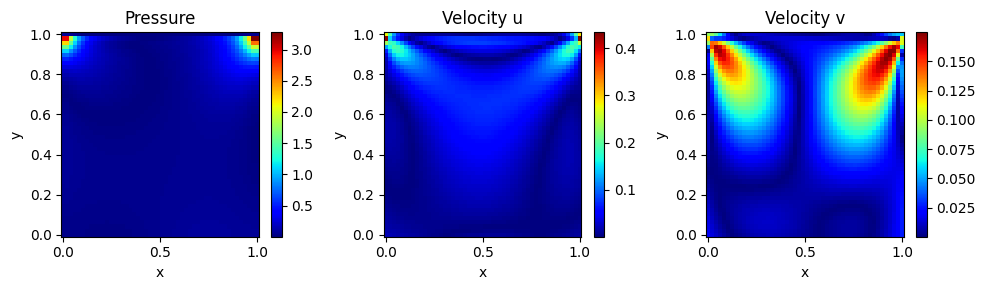

Mean squared error for velocity u: 0.0024996187717158725
Mean squared error for velocity v: 0.0028775476990233477


In [34]:
plot_pressure_velocity(x_test, y_test, u_diff, v_diff, p_diff)
print(f"Mean squared error for velocity u: {np.mean(u_diff**2)}")
print(f"Mean squared error for velocity v: {np.mean(v_diff**2)}")